In [ ]:
FRAME_SIZE = 125
HOP_RATIO = 0.1
N_FFT = 1024
VIGILANCE = 1.4
BUFFER_SIZE = 2

In [19]:
from modules.AudioProcessor import AudioProcessor

audio_files = [
    './dataset/trimmed_crowd_talking.mp3',
    './dataset/trimmed_motor_riding.mp3',
    './dataset/trimmed_water_flowing.mp3'
]
ap = AudioProcessor(
    audio_files, 
    frame_size_ms=FRAME_SIZE, 
    hop_length_ratio=HOP_RATIO
    )
print(ap.frames.shape)
print(ap.class_ids.shape)
print(ap.timestamps.shape)

torch.Size([28773, 6000])
(28773,)
(28773,)


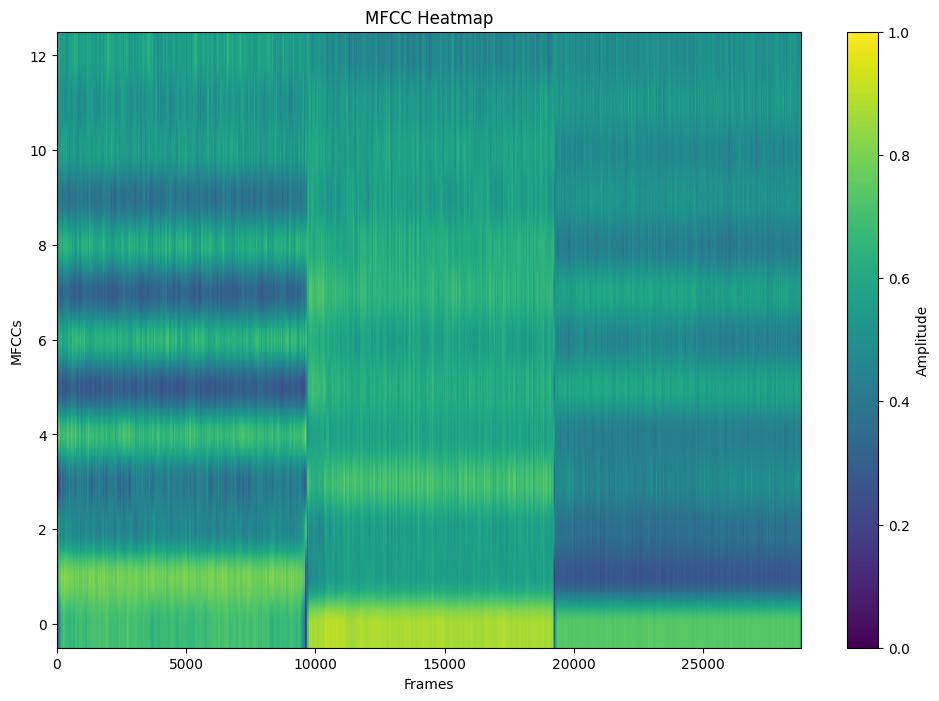

torch.Size([28773, 13])

In [20]:
from modules.FeatureExtractor import FeatureExtractor

fe = FeatureExtractor(n_fft=N_FFT)
fe.extract_mfcc(ap.frames)
fe.plot_mfccs()
fe.mfcc_features.shape

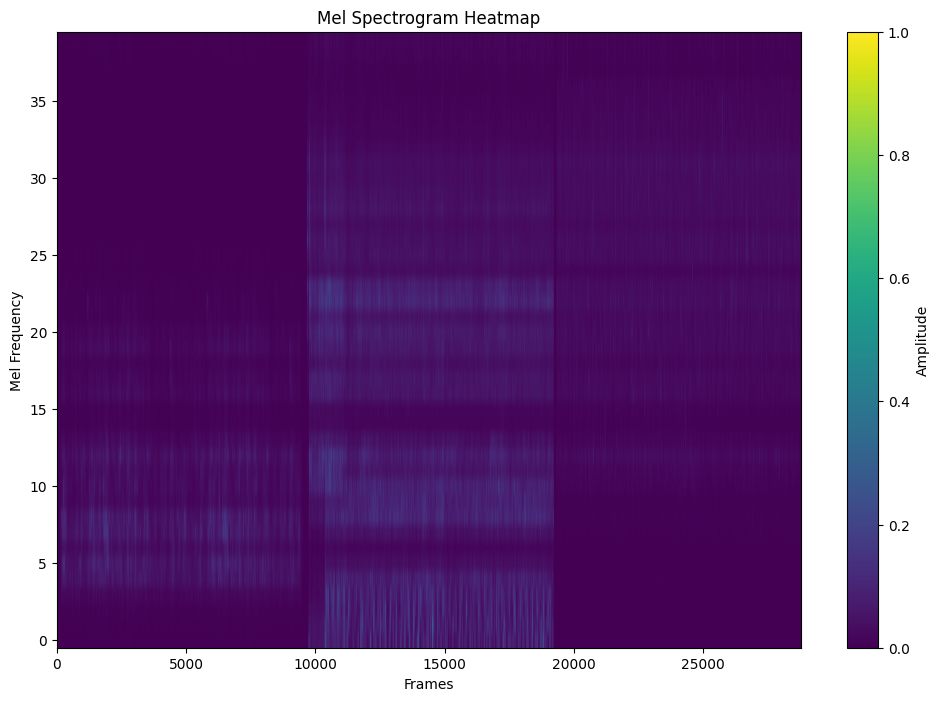

torch.Size([28773, 40])

In [21]:
fe.extract_melspectrogram(ap.frames)
fe.plot_melspectrogram()
fe.melspectrogram_features.shape

In [22]:
important_mfcc_features = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]
important_mfsc_features = [i for i in range(14)] + [i for i in range(16, 35)]

from modules.DatasetHandler import DatasetHandler

dh = DatasetHandler(
    ap.class_ids,
    ap.timestamps, 
    fe.mfcc_features, 
    fe.melspectrogram_features, 
    len(important_mfcc_features) + len(important_mfsc_features)
)
dh.generate_csv()
dh.save_selected_features(important_mfcc_features, important_mfsc_features)

time_series_tensor = dh.generate_time_series(FRAME_SIZE, HOP_RATIO)
time_series_tensor.shape

torch.Size([5, 9600, 44])

Clustering samples for time series 0
Clustering completed
Confusion matrix:
[[3177    0    0]
 [3189    0    0]
 [1279 1955    0]]
Accuracy: 53.583333333333336%


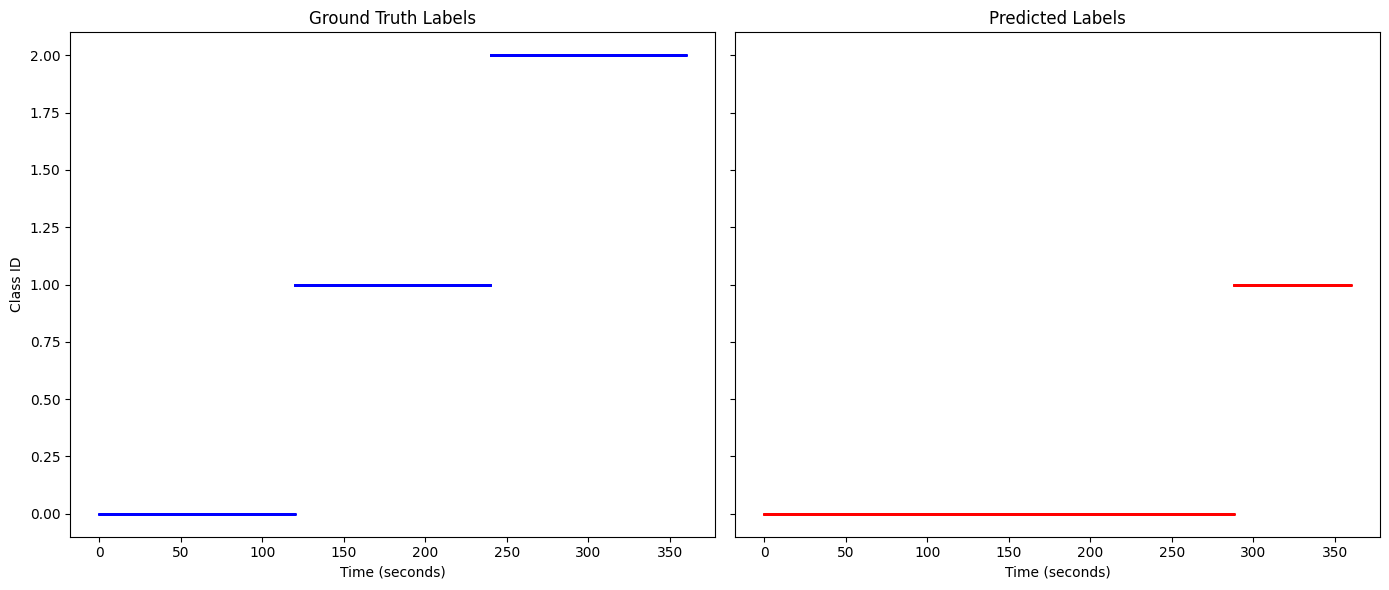

---------------------------------------------------------------------------

Clustering samples for time series 1
Clustering completed
Confusion matrix:
[[3212    0    0]
 [3210    0    0]
 [3173    5    0]]
Accuracy: 33.510416666666664%


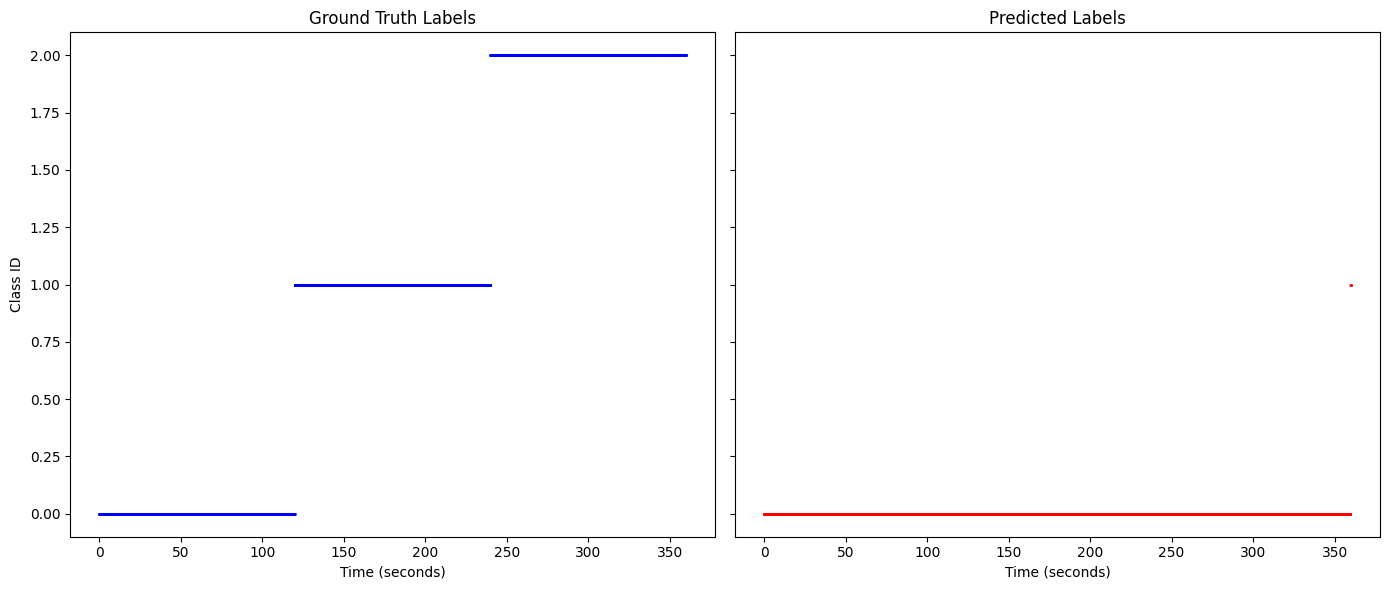

---------------------------------------------------------------------------

Clustering samples for time series 2
Clustering completed
Confusion matrix:
[[3166    0    0]
 [3267    0    0]
 [3167    0    0]]
Accuracy: 34.03125%


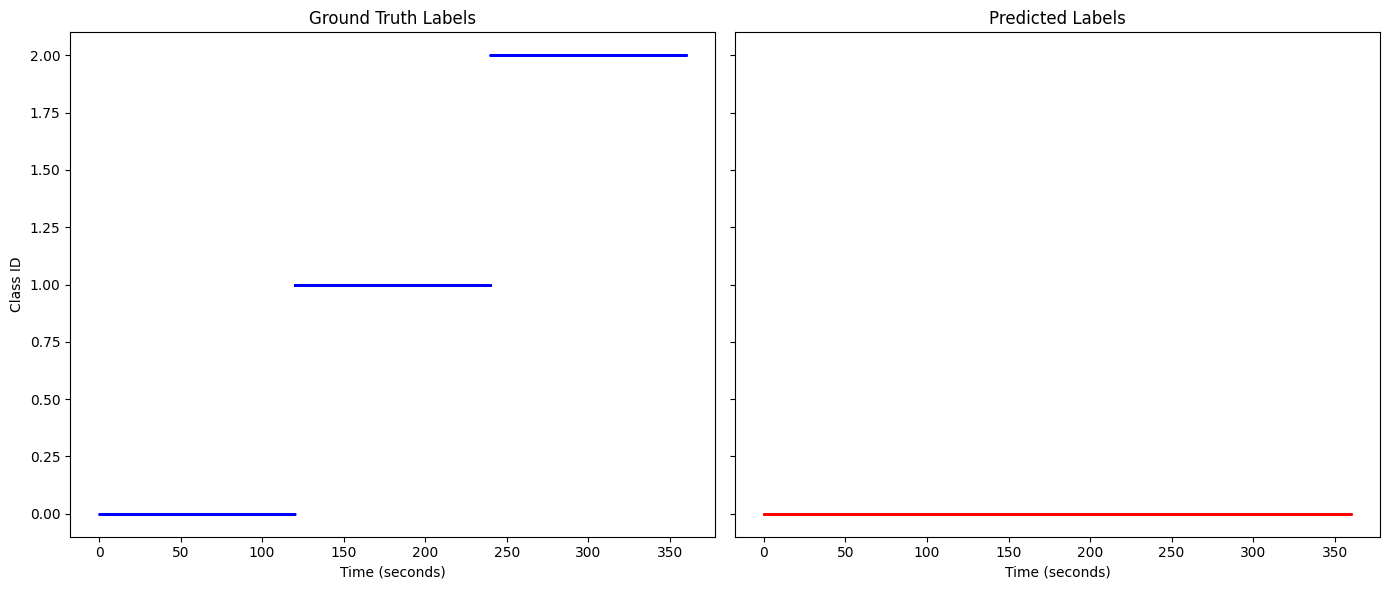

---------------------------------------------------------------------------

Clustering samples for time series 3
Clustering completed
Confusion matrix:
[[3211    0    0]
 [3215    0    0]
 [3174    0    0]]
Accuracy: 33.489583333333336%


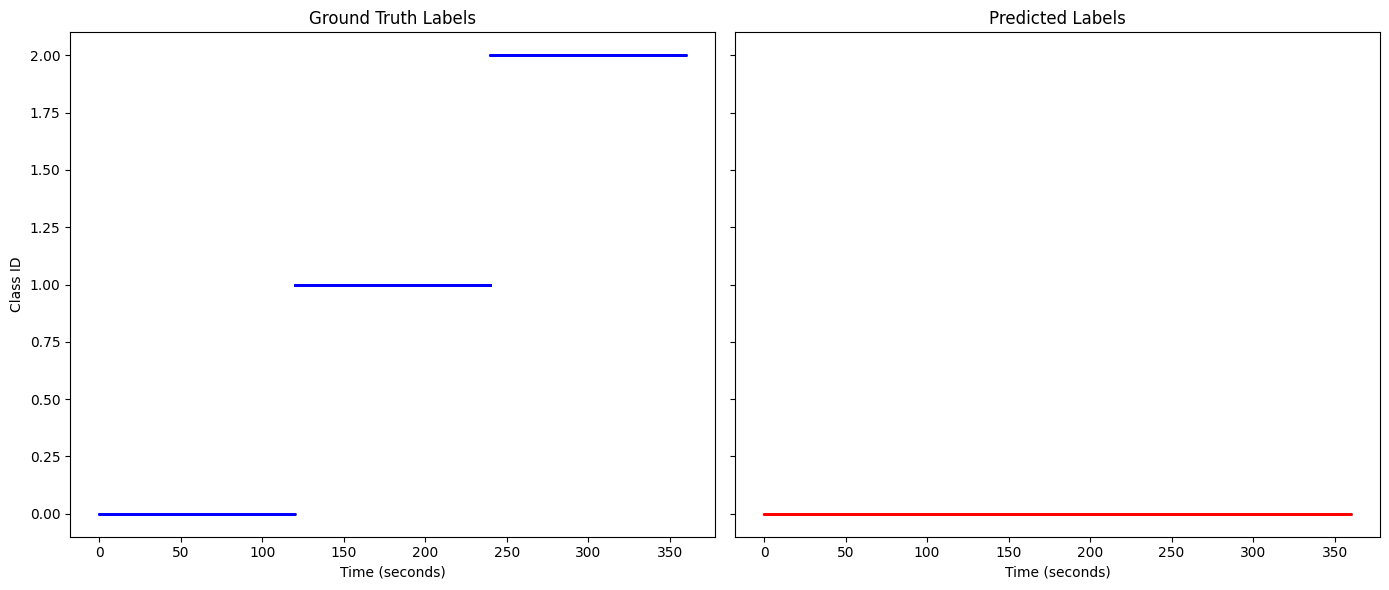

---------------------------------------------------------------------------

Clustering samples for time series 4
Clustering completed
Confusion matrix:
[[3184    0    0]
 [3175    0    0]
 [3241    0    0]]
Accuracy: 33.760416666666664%


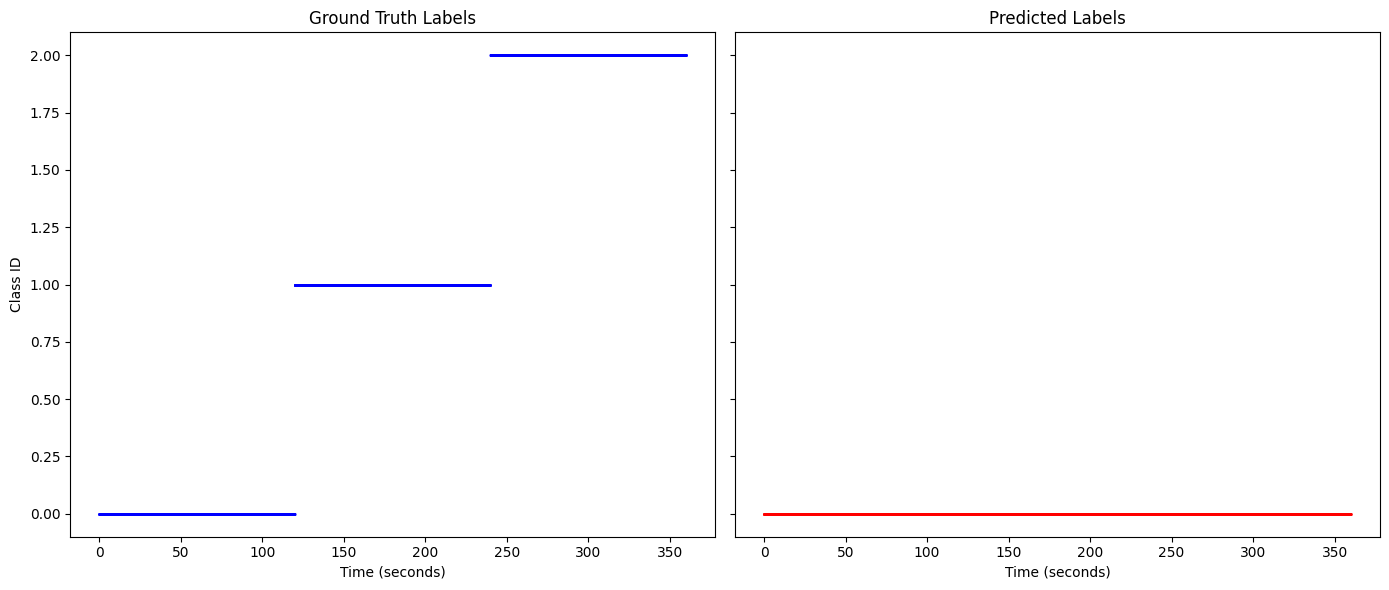

---------------------------------------------------------------------------

Overall accuracy: 37.675000000000004%


In [25]:
import importlib
import modules.ART2Clusterer
importlib.reload(modules.ART2Clusterer)
from modules.ART2Clusterer import SmoothingART2Clusterer

overall_accuracy = 0
for i in range(len(time_series_tensor)):
    clusterer = SmoothingART2Clusterer(
        vigilance=VIGILANCE, 
        n_features=time_series_tensor.shape[2],
        n_clusters=20,
        max_samples_per_cluster=time_series_tensor.shape[1]+1,
        buffer_size=BUFFER_SIZE
    )
    print(f"Clustering samples for time series {i}")
    for j, sample in enumerate(time_series_tensor[i]):
        clusterer.fit_clusters(sample, j)

    print("Clustering completed")
    confusion_matrix, accuracy = clusterer.calc_accuracy(f'./output/ground_truth_{i}.csv')
    print(f"Confusion matrix:\n{confusion_matrix}")
    print(f"Accuracy: {accuracy*100}%")
    clusterer.plot_truth_vs_time(f'./output/ground_truth_{i}.csv')
    overall_accuracy += accuracy
    print("-" * 75 + "\n")

print(f"Overall accuracy: {(overall_accuracy/5)*100}%")